In [517]:
import pydp
import os
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import scipy.stats
import re

%matplotlib inline

# 1. Preliminary Online Screening Questionnaires

#### Survey or Test/BIDS TSV Name
- Alcohol Use Disorders Identification Test (AUDIT)	audit.tsv
- Demographics	demographics.tsv
- Drug Use Questionnaire	drug_use.tsv
- Edinburgh Handedness Inventory (EHI)	ehi.tsv
- Health History Questions	health_history_questions.tsv
- Health Rating	health_rating.tsv
- Mental Health Questions	mental_health_questions.tsv
- World Health Organization Disability Assessment Schedule 2.0 (WHODAS 2.0)	whodas.tsv

In [601]:
def merge_specific_tsv_files(file_list, output_file, join_column):
    # Get the current working directory
    directory = os.getcwd()

    # Initialize an empty list to hold DataFrames
    dataframes = []

    # Read each specified TSV file into a DataFrame and add it to the list
    for file in file_list:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path, sep='\t')
        dataframes.append(df)

    # Merge all DataFrames on the specified column
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on=join_column, how='outer')

    # Save the merged DataFrame to a new TSV file
    merged_df.to_csv(output_file, sep='\t', index=False)

preliminary_files = ['participants_copy.tsv',
'demographics.tsv']



merge_specific_tsv_files(preliminary_files, 'pre_files_merged.tsv', 'participant_id')
preliminary_screening = pd.read_table("pre_files_merged.tsv")


#No reason to use these variables as they are mostly Nan or identical to each other. 
preliminary_screening = preliminary_screening.drop(columns=[
    'CURRENT_GENDER', 'CURRENT_GENDER_2', 'CURRENT_GENDER_SPFY', 'LGBT_IDENTITY_2',
    'LGBT_IDENTITY_SPFY', 'RACE_1_2', 'RACE_1_3', 'RACE_1_4', 'RACE_1_SPFY',
    'PARTICIPATE_NIH_STUDY', 'TRANSPORTATION', 'REFERRAL_TYPE', 'REFERRAL_TYPE_SECONDARY',
    'REFERRAL_TYPE_SECONDARY_2', 'REFERRAL_TYPE_SECONDARY_3', 'REFERRAL_TYPE_SECONDARY_4',
    'PARTICIPATE_STUDY', 'PARTICIPATE_STUDY_2', 'PARTICIPATE_STUDY_3', 'PARTICIPATE_STUDY_4','AGE',
    'GENDER'
    
])


preliminary_screening = preliminary_screening.drop(columns=[
    'MRI', 'MEG', 'cbc_with_differential', 'vitamin_levels', 'hematology', 'blood_chemistry',
    'acute_care', 'urinalysis', 'infectious_disease', 'urine_chemistry', 'lipid', 'hepatic',
    'scid5', 'whodas', 'drug_use', 'ehi', 'kbit2_vas', 'health_history_questions',
    'perceived_health_rating', 'ace', 'satisfaction', 'demographics', 'bdi', 'health_rating',
    'nih_toolbox', 'audit', 'figs', 'mri_variables', 'clinical_variable_form',
    'mental_health_questions', 'bai','eligibility','other'
])



#investigate if there is a disparency between the answers of age in the two columns likewise in gender
""""
#are_columns_equal = preliminary_screening['age'].equals(preliminary_screening['AGE'])
#diff_rows = preliminary_screening[preliminary_screening['age'] != preliminary_screening['AGE']]

#print(are_columns_equal)
#len(diff_rows)
#diff_rows

#diff_rows = preliminary_screening[preliminary_screening['sex'] != preliminary_screening['GENDER']]
#diff_rows
"""

preliminary_screening.replace([-999, -777], np.nan, inplace=True)


# 'audit.tsv' (sensitive attribute about drinking habits, therefor removed for now) 
# 'drug_use.tsv' (sensitive attribute therefor taken out)
# 'ehi.tsv', (I am not sure it has something to with how you move e.g. what hand do you use. fork) (ask cyril if this is relevant)
# 'health_rating.tsv' (sensitive attribute subjective of how you rate your health) (could potentially add noise here)
# 'whodas.tsv' (sensitive attribute questions about overall wellbeing)
# 'health_history_questions.tsv' (sensitive attribute)
# 'mental_health_questions.tsv' (sensitive attribute)
# Create a mapping dictionary
mapping = {'female': 2, 'male': 1}
# Convert 'sex' column using map function, ignore NaN values
preliminary_screening['sex'] = preliminary_screening['sex'].map(mapping).astype(float).astype(pd.Int64Dtype())

#we need to make handedness into numerical values
#left handed = 1
#right handed = 2
#ambidextrous = 3 

handedness_mapping = {'left': 1, 'right': 2, 'ambidextrous': 3}
# Map 'handedness' column and handle NaN values
preliminary_screening['handedness'] = preliminary_screening['handedness'].map(handedness_mapping)


print(preliminary_screening.columns)

Index(['participant_id', 'age', 'sex', 'handedness', 'LGBT_IDENTITY', 'RACE_1',
       'ETHNICITY_1', 'SETTING', 'EDUCATION', 'MARITAL_STATUS', 'INCOME',
       'EMPLOYMENT', 'WORK_NIH_CAMPUS', 'LANGUAGE', 'OTHER_LANGUAGE'],
      dtype='object')


In [602]:
#!cat participants_copy.json

In [603]:
preliminary_screening['LANGUAGE'] = preliminary_screening['LANGUAGE'].str.lower().str.strip()
# Replace specific values
preliminary_screening['LANGUAGE'] = preliminary_screening['LANGUAGE'].replace({
    'englush': 'english',  
    'enlgish':'english',
    'engliash':'english',
    'englich': 'english'# Replace 'Englush' with 'English'
    # Add more replacements here if needed
})
preliminary_screening['LANGUAGE'] = preliminary_screening['LANGUAGE'].replace('-999', np.nan)
preliminary_screening['OTHER_LANGUAGE'] = preliminary_screening['OTHER_LANGUAGE'].replace('-999', np.nan)


preliminary_screening['OTHER_LANGUAGE'] = preliminary_screening['OTHER_LANGUAGE'].str.lower().str.strip()


print(preliminary_screening['LANGUAGE'].unique())
preliminary_screening['LANGUAGE'].isna().sum()
print('\n')
print(preliminary_screening['OTHER_LANGUAGE'].unique())

['english' 'russian' 'turkish' 'spanish' 'portuguese' nan 'bulgarian'
 'malayalam' 'german' 'french' 'chinese' 'asl' 'tamil, english'
 'english/french' 'hebrew' 'swahili' 'japanese' 'slovene' 'vietnamese'
 'bisaya' 'filipino' 'urdu' 'amharic' 'the english as she is spoken'
 'english and arabic' 'pashto' 'swedish']


[nan 'french, german, vietnamese' 'hindi' 'english' 'burmese'
 'a little french' 'none' 'spanish' 'some spanish' 'french' 'swahili'
 'spanish, french' 'twi' 'german' 'spanish, german' 'chinese'
 'english and french' 'korean' 'some german' 'english, french'
 'russian, spanish' 'amharic' 'tagalog' 'japanese' 'spanish, portuguese'
 'hebrew' 'spanish, italian' 'na' 'french, german, swedish' 'farsi'
 'french, spanish' 'vietnamese' 'french, italian' 'hindi, spanish'
 'catalan and english' 'french (conversationally)' 'english, catalan'
 'english, polish, russian' 'italian, spanish, swedish'
 'filipino, japanese' 'n/a' 'french, german' 'mandarin' 'urdu, spanish'
 'english, hindi' '

In [604]:
preliminary_screening[preliminary_screening['WORK_NIH_CAMPUS'] == 1][0:3]

,participant_id,age,sex,handedness,LGBT_IDENTITY,RACE_1,ETHNICITY_1,SETTING,EDUCATION,MARITAL_STATUS,INCOME,EMPLOYMENT,WORK_NIH_CAMPUS,LANGUAGE,OTHER_LANGUAGE
5,sub-ON00740,21.0,2,2.0,0.0,5.0,0.0,1.0,3.0,1.0,4.0,0.0,1.0,english,NaN
12,sub-ON00963,63.0,2,2.0,0.0,5.0,0.0,1.0,4.0,1.0,8.0,0.0,1.0,russian,english
14,sub-ON01802,30.0,1,2.0,0.0,5.0,0.0,3.0,3.0,2.0,8.0,0.0,1.0,english,a little french


work in campus, speaks russian, 63 years, female, lives in surburbs, Advanced/professional degree 
Single/Never married, Income 100,001 to 150,000,  Full time contract. 

Here is by simple google search a list of all employees at the campus https://www.nimh.nih.gov/about/staff-directories/alphabetical-listing-of-all-staff.  


In [605]:
# Solution is to remove the WORK-AT-NIH column. 
# The Same is applicable for Employment as this variable teoretically should have no influence on MRI scans. 
# The same i relevant for Marital Status, ETHNICITY_1 & Setting 

preliminary_screening = preliminary_screening.drop(columns=[
    'WORK_NIH_CAMPUS', 'MARITAL_STATUS','SETTING','EMPLOYMENT','ETHNICITY_1'])

In [606]:
print(preliminary_screening['age'].max())
print(preliminary_screening['age'].mean())
preliminary_screening[0:3]

89.0
38.46111111111111


,participant_id,age,sex,handedness,LGBT_IDENTITY,RACE_1,EDUCATION,INCOME,LANGUAGE,OTHER_LANGUAGE
0,sub-ON00041,25.0,2,2.0,0.0,2.0,3.0,9.0,english,NaN
1,sub-ON00430,33.0,2,2.0,0.0,5.0,3.0,9.0,english,NaN
2,sub-ON00541,28.0,2,2.0,0.0,6.0,3.0,6.0,english,NaN


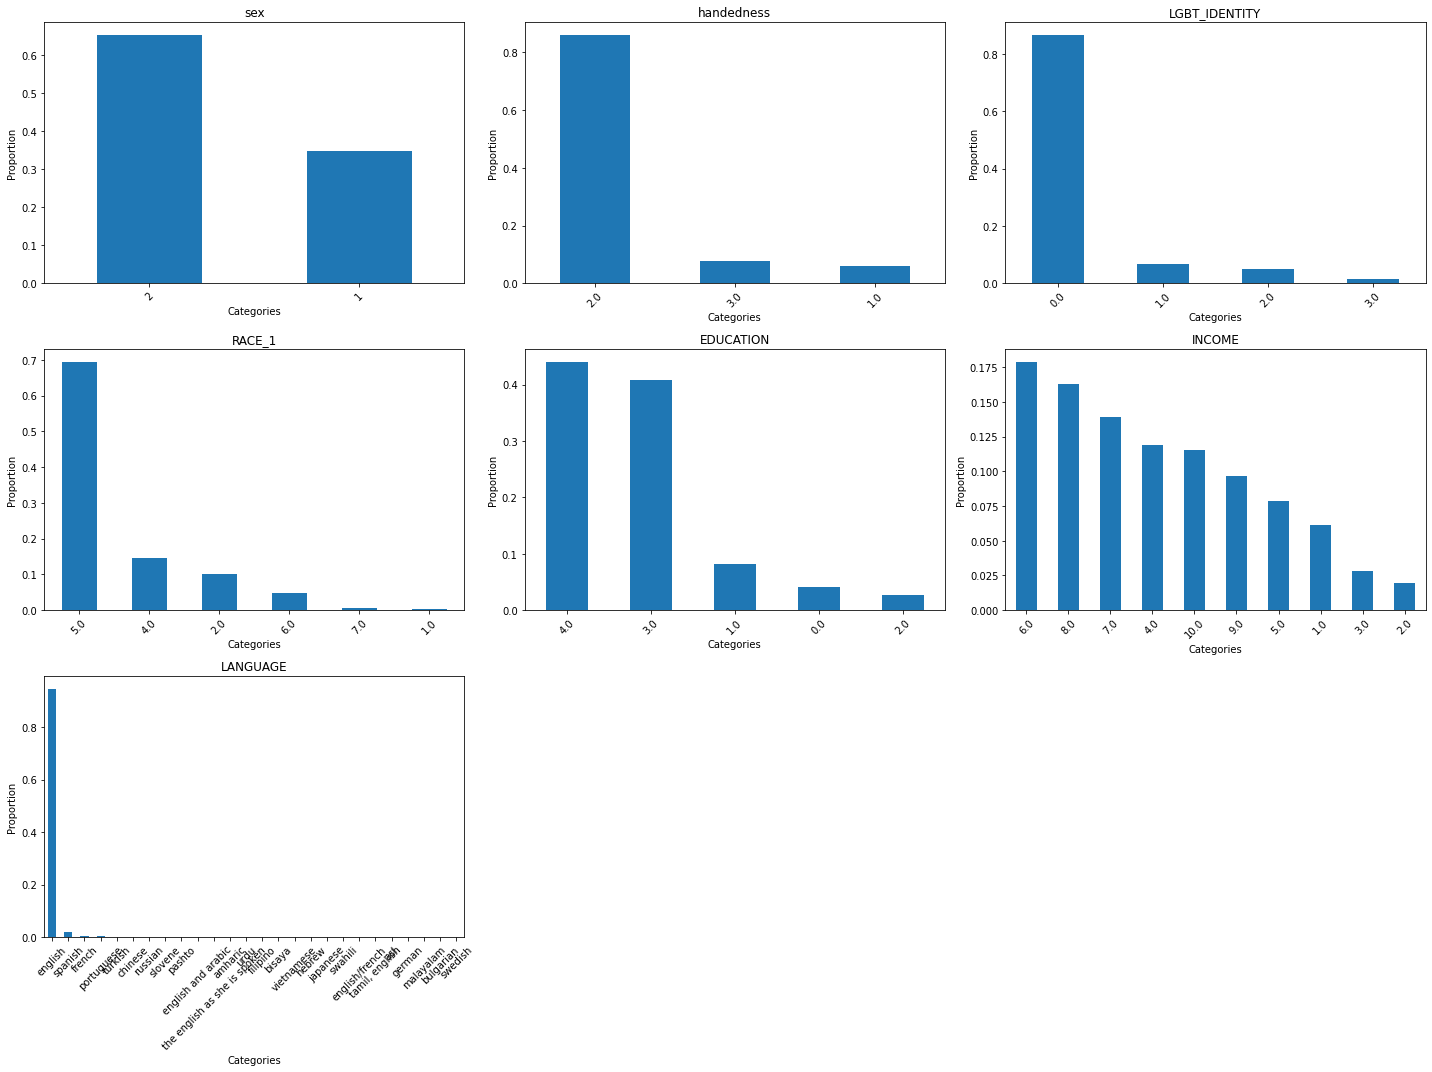

In [607]:
columns_to_plot = [col for col in preliminary_screening.columns if col not in ['participant_id', 'age','OTHER_LANGUAGE']]

# Calculate value counts and normalize for each relevant column
value_counts_dict = {}
for column in columns_to_plot:
    value_counts_dict[column] = preliminary_screening[column].value_counts(normalize=True)


num_cols = len(columns_to_plot)
num_rows = (num_cols + 2) // 3  


fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))  # Adjust figsize as needed


axes = axes.flatten()


for i, (column, ax) in enumerate(zip(columns_to_plot, axes)):
    value_counts_dict[column].plot(kind='bar', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability


for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Changeing the language category to billingual or not billingual
- No relevancy for individual based knowledge of languages instead we do:

    More than 1 language: yes = 1 no = 0.

In [608]:
preliminary_screening['LANGUAGE'].unique()

array(['english', 'russian', 'turkish', 'spanish', 'portuguese', nan,
       'bulgarian', 'malayalam', 'german', 'french', 'chinese', 'asl',
       'tamil, english', 'english/french', 'hebrew', 'swahili',
       'japanese', 'slovene', 'vietnamese', 'bisaya', 'filipino', 'urdu',
       'amharic', 'the english as she is spoken', 'english and arabic',
       'pashto', 'swedish'], dtype=object)

In [609]:
def split_languages(entry):
    if pd.isna(entry):
        return [entry, np.nan]
    # Split by ',', '/', 'and' with spaces around
    split_entry = re.split(r'\s+and\s+|,\s*|/\s*', entry)
    split_entry = [lang.strip() for lang in split_entry]
    if len(split_entry) == 1:
        split_entry.append(np.nan)
    return split_entry

preliminary_screening[['LANGUAGE', 'LANGUAGE_1']] = preliminary_screening['LANGUAGE'].apply(lambda x: pd.Series(split_languages(x)))

In [610]:
preliminary_screening['LANGUAGE'] = preliminary_screening['LANGUAGE'].replace('the english as she is spoken', 'english')
preliminary_screening['LANGUAGE'] = preliminary_screening['LANGUAGE'].apply(lambda x: 0 if pd.notna(x) and x.strip().lower() == 'english' else 1)

In [611]:
preliminary_screening['LANGUAGE_1'] = preliminary_screening['LANGUAGE_1'].apply(lambda x: 0 if pd.isna(x) else 1)
preliminary_screening['LANGUAGE_1'].unique()

array([0, 1])

In [612]:
#preliminary_screening['OTHER_LANGUAGE'].unique()
preliminary_screening['OTHER_LANGUAGE'] = preliminary_screening['OTHER_LANGUAGE'].replace(to_replace=r'\b(no|none|na|ga)\b', value=np.nan, regex=True)
preliminary_screening['OTHER_LANGUAGE'] = preliminary_screening['OTHER_LANGUAGE'].apply(lambda x: 0 if pd.isna(x) else 1)
preliminary_screening['OTHER_LANGUAGE'].unique()


array([0, 1])

In [613]:
preliminary_screening['BILINGUAL'] = preliminary_screening.apply(lambda row: 0 if (row['LANGUAGE'] == 0 and row['OTHER_LANGUAGE'] == 0 and row['LANGUAGE_1'] == 0) else 1, axis=1)
preliminary_screening = preliminary_screening.drop(columns=['LANGUAGE', 'OTHER_LANGUAGE', 'LANGUAGE_1'])


### We are going to remove income as it is set as household income and not individual earned income 


In [614]:
preliminary_screening = preliminary_screening.drop(columns=['INCOME'])

### We are going to remove education. 

In [615]:
preliminary_screening = preliminary_screening.drop(columns=['EDUCATION'])


In [616]:
preliminary_screening

,participant_id,age,sex,handedness,LGBT_IDENTITY,RACE_1,BILINGUAL
0,sub-ON00041,25.0,2,2.0,0.0,2.0,0
1,sub-ON00430,33.0,2,2.0,0.0,5.0,0
2,sub-ON00541,28.0,2,2.0,0.0,6.0,0
3,sub-ON00632,75.0,1,1.0,0.0,5.0,1
4,sub-ON00641,23.0,2,2.0,0.0,2.0,1
...,...,...,...,...,...,...,...
1085,sub-ON99944,28.0,1,2.0,0.0,5.0,0
1086,sub-ON99963,36.0,2,1.0,2.0,5.0,0
1087,sub-ON99973,79.0,2,2.0,0.0,5.0,0
1088,sub-ON99974,23.0,2,2.0,0.0,4.0,0


In [617]:
!cat demographics.json

{
    "AGE": {
        "LongName": "AGE (question ID 208)",
        "Description": "1. What is your current age?"
    },
    "GENDER": {
        "LongName": "GENDER (question ID 117530)",
        "Description": "2. What sex were you assigned at birth, on your original birth certificate?",
        "Levels": {
            "1": "Male",
            "2": "Female"
        }
    },
    "CURRENT_GENDER": {
        "LongName": "CURRENT_GENDER (question ID 209499), first endorsement",
        "Description": "3. What is your current gender identity? (Check all that apply)",
        "Levels": {
            "0": "Male",
            "1": "Female",
            "2": "Trans male/Trans Man",
            "3": "Trans female/Trans woman",
            "4": "Genderqueer/Gender non-conforming",
            "5": "Different identity"
        }
    },
    "CURRENT_GENDER_2": {
        "LongName": "CURRENT_GENDER (question ID 209499), second endorsement",
        "Description": "3. What is your current gender ide

### Combining  "6": "Multiple race", "7": "Unknown" ,   "3": "Hawaiian/Pacific Islander", "2": "Asian" and "4": "Black/African American", "1": "American Indian/Alaska Native" into 1 group : Non-Caucasian 
     

In [618]:
preliminary_screening['RACE_1'] = preliminary_screening['RACE_1'].replace([1, 2, 3, 4, 6, 7], 0)

### Removing LGBT Column

In [619]:
preliminary_screening = preliminary_screening.drop(columns=['LGBT_IDENTITY'])


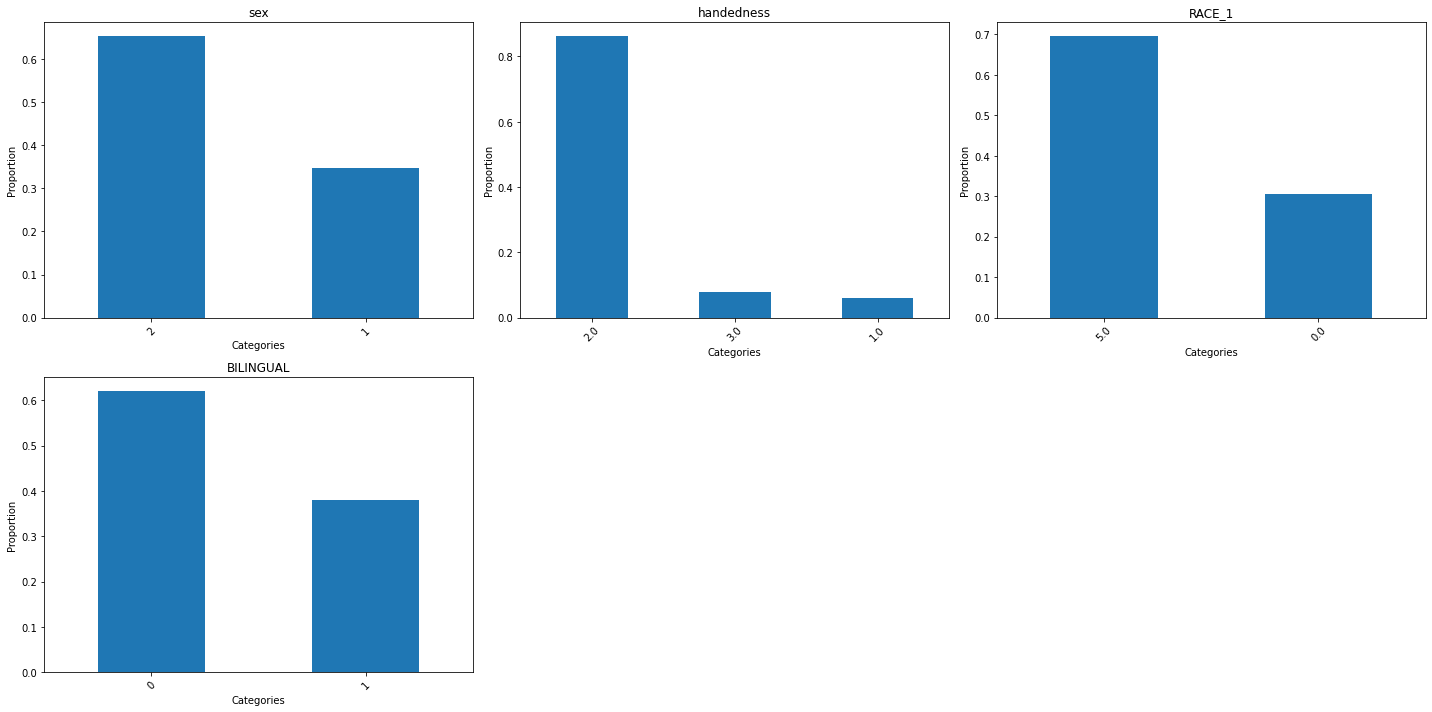

In [620]:
# Assuming preliminary_screening is your DataFrame
columns_to_plot = [col for col in preliminary_screening.columns if col not in ['participant_id', 'age','OTHER_LANGUAGE']]

# Calculate value counts and normalize for each relevant column
value_counts_dict = {}
for column in columns_to_plot:
    value_counts_dict[column] = preliminary_screening[column].value_counts(normalize=True)

# Determine the number of rows and columns for subplots
num_cols = len(columns_to_plot)
num_rows = (num_cols + 2) // 3  # Calculate number of rows needed (ceil(num_cols / 3))

# Create subplots with adjusted layout
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))  # Adjust figsize as needed

# Flatten axes array to handle indexing in a single loop
axes = axes.flatten()

# Plot each relevant column's value counts
for i, (column, ax) in enumerate(zip(columns_to_plot, axes)):
    value_counts_dict[column].plot(kind='bar', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Hide empty subplots if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [621]:
preliminary_screening

,participant_id,age,sex,handedness,RACE_1,BILINGUAL
0,sub-ON00041,25.0,2,2.0,0.0,0
1,sub-ON00430,33.0,2,2.0,5.0,0
2,sub-ON00541,28.0,2,2.0,0.0,0
3,sub-ON00632,75.0,1,1.0,5.0,1
4,sub-ON00641,23.0,2,2.0,0.0,1
...,...,...,...,...,...,...
1085,sub-ON99944,28.0,1,2.0,5.0,0
1086,sub-ON99963,36.0,2,1.0,5.0,0
1087,sub-ON99973,79.0,2,2.0,5.0,0
1088,sub-ON99974,23.0,2,2.0,0.0,0


In [622]:
grouped = preliminary_screening.groupby(['sex', 'handedness', 'RACE_1', 'BILINGUAL']).size().reset_index(name='count')

# Check the minimum count to determine k-anonymity
min_count = grouped['count'].min()

print(f"Minimum count of any unique combination: {min_count}")

# Define k for k-anonymity (e.g., 2, 5, 10, etc.)
k = 2

# Check if all unique combinations satisfy k-anonymity
is_k_anonymous = all(count >= k for count in grouped['count'])
print(f"Is the dataset k-anonymous (k={k})? {is_k_anonymous}")

Minimum count of any unique combination: 2
Is the dataset k-anonymous (k=2)? True


0


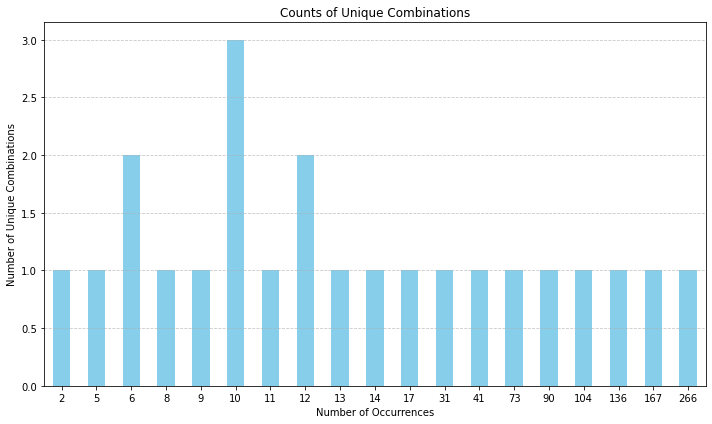

In [623]:
print(len(grouped[grouped['count'] == 1]))

plt.figure(figsize=(10, 6))
grouped['count'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Counts of Unique Combinations')
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Unique Combinations')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [600]:
grouped[grouped['count'] == 1]

,sex,handedness,RACE_1,BILINGUAL,count
10,1,3.0,4.0,1,1


#### 4 unique identifiable people. Meaning would we know someone participating in this study who is a male, left handed, gay, caucasian and bilingual we could identify them. 

In [474]:
grouped[grouped['count'] == 2]

,sex,handedness,RACE_1,BILINGUAL,count
0,1,1.0,0.0,0,2


#### I wanna look for correlation in case it is possible for an adversary to estimate other values based on strong correlation. 

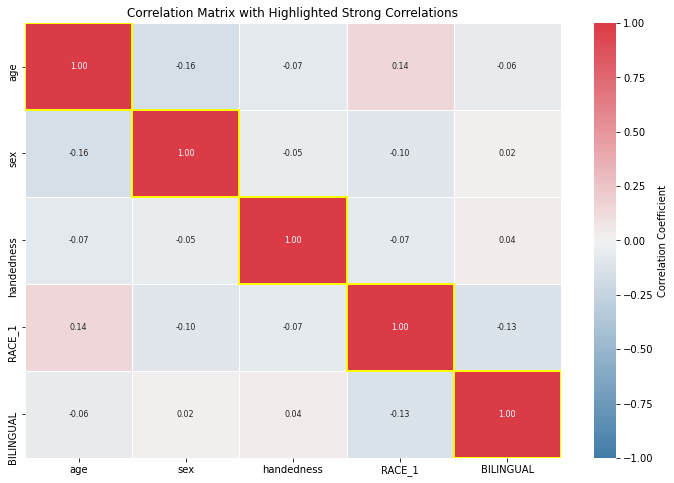

In [475]:
# Calculate correlation matrices
corr_matrix_original = preliminary_screening.corr()
corr_matrix_original

cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)  # Blue to red palette

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_original, cmap=cmap, vmin=-1, vmax=1, center=0, 
            cbar_kws={'label': 'Correlation Coefficient'}, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 8})


for i in range(len(corr_matrix_original.columns)):
    for j in range(len(corr_matrix_original.columns)):
        if corr_matrix_original.iloc[i, j] > 0.5 or corr_matrix_original.iloc[i, j] < -0.5:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='yellow', lw=2))

plt.title('Correlation Matrix with Highlighted Strong Correlations')
plt.show()

In [34]:
pre_noise = preliminary_screening.copy()
type(pre_noise)

pandas.core.frame.DataFrame

In [625]:
import numpy as np
import pandas as pd

# Function to perturb age with Laplace noise using fixed sensitivity and bounds
def perturb_age(age, sensitivity, epsilon, lower_bound, upper_bound):
    noisy_age = age + np.random.laplace(0, sensitivity / epsilon)
    # Apply bounds to noisy age
    noisy_age = max(lower_bound, min(noisy_age, upper_bound))
    return noisy_age


# Fixed sensitivity for age 
sensitivity = 71

# Privacy parameter (epsilon)
epsilon = 1.0  

# Define bounds
lower_bound = 18  
upper_bound = 90  

pre_noise['age'] = preliminary_screening['age'].apply(perturb_age, args=(sensitivity, epsilon, lower_bound, upper_bound))


mean_age_noisy = pre_noise['age'].mean()
print("Noisy mean age:", mean_age_noisy)


Noisy mean age: 57.26771763412763


In [626]:
print(pre_noise['age'].max())
print(pre_noise['age'].min())

90.0
18.0


### Privaticing the drug_use.tsv file.
#### These attributes are sensitive attributes e.g. 

##### "dsm_subs_use_08": {
#####        "LongName": "DSM5_SUBSTANCE_8 (question ID 209935)",
#####        "Description": "h. Heroin",
#####        "Levels": {
#####            "0": "0- Not at all",
#####            "1": "1- One or two days",
#####            "2": "2- Several days",
#####            "3": "3- More than half the days",
#####            "4": "4- Nearly every day"
#####        }
#####    },


answer 4 would indicate some sort of dependency. 

In [1]:
!cat  drug_use.json

{
    "participant_id": {
        "Description": "OpenNeuro ID of the subject."
    },
    "dsm_subs_use_01": {
        "LongName": "DSM5_SUBSTANCE_1 (question ID 209928)",
        "Description": "a. Painkillers (like Vicodin)",
        "Levels": {
            "0": "0- Not at all",
            "1": "1- One or two days",
            "2": "2- Several days",
            "3": "3- More than half the days",
            "4": "4- Nearly every day"
        }
    },
    "dsm_subs_use_02": {
        "LongName": "DSM5_SUBSTANCE_2 (question ID 209929)",
        "Description": "b. Stimulants (like Ritalin, Adderall)",
        "Levels": {
            "0": "0- Not at all",
            "1": "1- One or two days",
            "2": "2- Several days",
            "3": "3- More than half the days",
            "4": "4- Nearly every day"
        }
    },
    "dsm_subs_use_03": {
        "LongName": "DSM5_SUBSTANCE_3 (question ID 209930)",
        "Description": "c. Sedatives or tranquilizers (like sleeping p

In [ ]:
# audit12_04a, audit_02_4

In [491]:
alcohol_use  = pd.read_csv('audit.tsv', sep='\t')
alcohol_use

,participant_id,"audit_02_1, audit_1_1month, audit_1_bl, audit_1_fu","audit_02_2, audit_2_1month, audit_2_bl, audit_2_fu","audit_02_3, audit_3_1month, audit_3_bl, audit_3_fu","audit12_04a, audit_02_4","audit12_05a, audit_02_5","audit12_06a, audit_02_6","audit12_07a, audit_02_7","audit12_08a, audit_02_8","audit_02_9, audit_9_1month, audit_9_bl, audit_9_fu","audit_10, audit_10_1month, audit_10_bl, audit_10_fu"
0,sub-ON00041,1,0,0,0,0,0,1,1,0,0
1,sub-ON00430,1,0,0,0,0,0,0,0,0,0
2,sub-ON00541,4,1,2,0,1,0,1,1,0,0
3,sub-ON00632,4,0,0,0,0,0,0,0,0,0
4,sub-ON00641,0,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1063,sub-ON99944,2,0,0,0,0,0,0,0,0,0
1064,sub-ON99963,0,5,0,0,0,0,0,0,0,0
1065,sub-ON99973,4,0,0,0,0,0,0,0,0,0
1066,sub-ON99974,3,0,1,0,0,0,0,0,0,0
